# 1. 프로젝트 : 뉴스기사 요약

<b><mark>[목  차]</mark></b><br>
<b>Step 1. 데이터 수집하기</b><br>
<b>Step 2. 데이터 전처리하기 (추상적 요약)</b><br>
1) 중복 샘플과 NULL 값이 존재하는 샘플 제거<br>
2) 텍스트 정규화와 불용어 제거<br>
- 텍스트 정규화 : 같은 표현 통일 시키기 / 불용어 : 별도움이 되지 않음 단어

3) 멀티프로세싱으로 데이터 전처리<br>
- 별도의 프로세스를 생성하여 병렬처리(소요시간 축소)

4) 훈련데이터와 테스트데이터 나누기<br>
- 학습 진행을 위한 데이터크기 결정 및 문장 시작, 끝 표시

5) 시작 토큰과 종료 토큰 추가하기<br>

6) 단어 집합(vocabulary) 만들기 및 정수 인코딩<br>
- 단어 집합 만들기 : 훈련데이터 및 테스트 데이터의 각 단어 마다 고유한 정수를 맵핑하는 작업

7) 패딩하기<br>

<b>Step 3. 어텐션 메커니즘 사용하기 (추상적 요약) </b><br>
1) 함수형 API를 이용해서 인코더를 설계<br>
2) 디코더 설계<br>
3) 어텐션 메커니즘 <br>
- 또 다른 신경망 생성

4) 모델 훈련하기<br>
- EarlyStopping(조기종료) : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patience=2(2회) 관측되면 학습을 멈추도록 설정

5) 인퍼런스 모델 구현<br>
6) 모델 테스트<br>

<b>Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)</b><br>
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교

<b>Step 5. Summa을 이용해서 추출적 요약해보기</b><br>
1) 데이터 다운로드 하기<br>
2) summarize 사용하기  <br>

In [1]:
#데이터 준비하기

import nltk  # NLTK(Natural Language Toolkit) : 영어 기호, 통계, 자연어 처리를 위한 라이브러리
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


## Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
72544,Rajasthan reported highest share of economic c...,With a total of 1 lakh and 50 thousand economi...
92865,Internet services suspended in Kashmir amid vi...,Jammu and Kashmir authorities on Tuesday suspe...
49334,Which captains have led India to ICC U-19 Worl...,Eighteen-year-old Prithvi Shaw led India to th...
39520,Rajinikanth urges Kannadigas not to disturb 'K...,Seeking the cooperation of the people of Karna...
19634,"Paytm parent posts Ã¢ÂÂ¹1,604 cr loss for fin...",Paytm's parent company One97 Communications ha...
29944,Congress-JD(S) to face floor test in Karnataka...,The floor test of the Congress-JD(S) alliance ...
16014,"Priyanka, Nick spotted with Sonam, Anand in Italy",Pictures of Priyanka Chopra and Nick Jonas wit...
51965,Cop suspended for dragging old man out of temp...,A Karnataka policeman has been suspended for d...
46088,Pak actress Sajal Ali reveals Sridevi's last m...,"Pakistani actress Sajal Ali, who played Sridev..."
41795,Robot teacher which can also dance being teste...,A language-teaching humanoid robot named Elias...


## Step 2. 데이터 전처리하기 (추상적 요약)
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

#### 1) 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
# 중복 셈플 유무 확인

print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique()) #

#데이터에 고유값들의 수를 출력해주는 함수

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
# drop_duplicates()를 사용, 손쉽게 중복 샘플을 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다.

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
# 중복제거후 .isnull().sum()으로 null값 유무 재확인 

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 데이터 프레임에서  null 값 제거 dropna() 함수 사용

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 2) 텍스트 정규화와 불용어 제거
- 텍스트 정규화 : 같은 표현 통일 시키기 
- 불용어 : 별도움이 되지 않음 단어

In [8]:
# 텍스트 정규화

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# 불용어제거

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 영어 소문자 변경, html 태그 솎아내기, 정규 표현식으로 특수문자 제거

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 자연스런 문장이 되기 위해 불용어들을 summary에 남겨두기
    # 불용어 제거 (Text)
    if remove_stopwords: 
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전처리 전, 후의 결과 확인을 위한 임의 함수 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


#### 3) 멀티프로세싱으로 데이터 전처리
- 별도의 프로세스를 생성하여 병렬처리(소요시간 축소)

In [12]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_headlines = preprocess_data(data['headlines'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_headlines)

clean_text = preprocess_data(data['text'], remove_stopwords=False) #불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False
print(clean_text)

46.3413405418396  seconds
['upgrad learner switches career ml al salary hike'
 'delhi techie wins free food swiggy one year cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'matrix film get reboot reports'
 'snoop dogg aims gun clown dressed trump new video'
 'madhesi morcha withdraws support nepalese government']
8.410540103912354  seconds
['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like

In [13]:
# 빈(empty) 샘플 확인

data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# null값 유무 재확인 

data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 4) 훈련데이터와 테스트데이터 나누기
- 학습 진행을 위한 데이터크기 결정 및 문장 시작, 끝 표시

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.180195201301345
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136183407889386


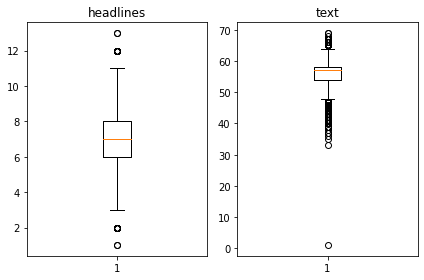

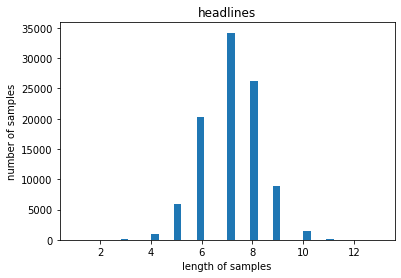

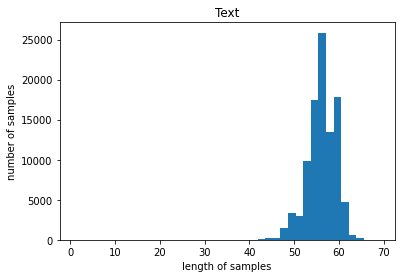

In [15]:
# 샘플의 최대 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 차례대로 각각 요약, 실제 텍스트의 길이 분포, 요약본 샘플 길이별 개수, 실제 텍스트 샘플 길이별 개수
- Text의 경우 최소 길이가 1, 최대 길이가 69로 그 차이가 크다. 
- headlines의 가장 많은 샘플은 6~8인 것으로 확인 되었다.
- text 가장 많은 샘플은 55~60인 것으로 확인 되었다.
- 텍스트의 평균 길이 평균 길이는 56으로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할수 있었다.

In [16]:
# text 의 최대 길이와 summary 의 적절한 최대 길이 임의로 정하기

text_max_len = 57
headlines_max_len = 7

In [17]:
# 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 57 이하인 샘플의 비율: 0.6258235054900366
전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.6264640097600651


<mark>[시도]
- 전체 샘플 중 길이가 57 이하인 샘플의 비율: 0.6258235054900366 / 전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.6264640097600651
- 전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443777958519723 / 전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8925782838552258
    
조정후 샘플의 비율의 변화를 확인 할수 있었다.
일부 버려지는 샘플을 위해 길이에 맞춰 자르지 말고, 정해진 길이보다 길면 제외하는 정제 필요하다. 

In [19]:
## 샘플들의 길이 중에서 max length 이하인 데이터들의 갯수를 알아보기

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 39924


#### 5) 시작 토큰과 종료 토큰 추가하기

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x) #시작 토큰
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken') #종료 토큰
data.head()

,headlines,text,decoder_input,decoder_target
6,india get lowest odi total new zealand,india recorded their lowest odi total in new z...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
12,ram krishna smoke ramdev sadhus kumbh,urging saints and seers at the kumbh mela to q...,sostoken ram krishna smoke ramdev sadhus kumbh,ram krishna smoke ramdev sadhus kumbh eostoken
18,long tolerate congress leaders potshots taka cm,days after he threatened to step down from his...,sostoken long tolerate congress leaders potsho...,long tolerate congress leaders potshots taka c...
20,think opposition even dreams pm modi,claiming there is dearth of ideas among opposi...,sostoken think opposition even dreams pm modi,think opposition even dreams pm modi eostoken
22,killed injured saudi arabia floods,at least people have been killed and others ha...,sostoken killed injured saudi arabia floods,killed injured saudi arabia floods eostoken


In [26]:
# decoder_input, decoder_target 레이블 각각 다시 numppy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [27]:
# 훈련 데이터와 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 2284 13957   613 ...  9723 24542 10538]


In [28]:
# 데이터의 샘플 순서를 정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [29]:
# 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리
    
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 7984


In [30]:
# 테스트 데이터개수 이용해 전체 데이터 나누기

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 31940
훈련 레이블의 개수 : 31940
테스트 데이터의 개수 : 7984
테스트 레이블의 개수 : 7984


#### 6) 단어 집합(vocabulary) 만들기 및 정수 인코딩
- 단어 집합 만들기 : 훈련데이터 및 테스트 데이터의 각 단어 마다 고유한 정수를 맵핑하는 작업

In [31]:
# 케라스 토크나이저 사용, 훈련 데이터로 부터 단어 집합 만들기

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [33]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어와 각 단어의 등장 빈도수가 저장
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 48000
등장 빈도가 6번 이하인 희귀 단어의 수: 33945
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 14055
단어 집합에서 희귀 단어의 비율: 70.71875
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.001292992729802


In [34]:
# 기준 : 위의 단어 집합에서 6번 이하 단어를 제외시킬 경우의 단어 집합의 크기 14055
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 정수로 잘 변경되었는지 샘플 출력
print(encoder_input_train[:3])

[[6806, 586, 4, 1, 54, 1332, 4, 248, 3755, 7, 113, 888, 526, 17, 37, 4606, 589, 1, 2988, 1, 1970, 2401, 11, 61, 4139, 16, 37, 515, 5, 3870, 2329, 3, 1, 2988, 3922, 1, 46, 7, 387, 160, 5, 40, 809, 2, 5292, 1, 1410, 751, 1, 227, 526], [1, 46, 7, 1091, 2243, 690, 8, 989, 20, 15, 1928, 34, 78, 2285, 5194, 1027, 4, 28, 58, 3923, 2, 894, 6, 150, 1, 46, 39, 231, 160, 4, 1194, 2, 778, 5, 50, 2286, 1491, 1, 2243, 9, 1, 701, 11, 666, 2, 2778, 2583, 2206, 10, 688, 2, 95], [5916, 2156, 5, 2244, 3, 118, 275, 4696, 761, 50, 583, 6, 3131, 5526, 87, 6, 1, 259, 4, 1, 571, 6223, 3535, 5527, 5526, 3025, 2, 648, 43, 70, 6, 1, 3756, 2, 761, 6224, 1971, 5, 461, 4, 2402, 5, 214, 1750, 5, 164]]


In [36]:
# Summary 데이터에 동일 작업 진행, 훈련 데이터로 부터 단어 집합 만들기

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

<mark><동일작업 > 
- 단어집합 만들기 > 빈도수 낮은 단어들 훈련데이터에서 제외 >  희귀 단어 집합 크기 제외 > 정수시퀀스로 변환

In [37]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 20877
등장 빈도가 5번 이하인 희귀 단어의 수: 14991
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 5886
단어 집합에서 희귀 단어의 비율: 71.80629400775975
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.976045369900119


In [38]:
# 기준 : 위의 단어 집합에서 5번 이하 단어를 제외시킬 경우의 단어 집합의 크기 5885 

tar_vocab = 2000  
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 정수로 잘 변경되었는지 샘플 출력
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1621, 1051, 1013, 146], [1, 501, 1076, 363, 131, 1765, 539], [1, 122, 37, 123], [1, 355, 142, 575, 93], [1, 222, 1103, 733]]
target
decoder  [[1621, 1051, 1013, 146, 2], [501, 1076, 363, 131, 1765, 539, 2], [122, 37, 123, 2], [355, 142, 575, 93, 2], [222, 1103, 733, 2]]


- 기준 : 위의 단어 집합에서 5번 이하 단어를 제외시킬 경우 단어 집합의 크기 5885, 학습한 LMS 노드 기준이 2000로 나와있어 그대로 적용

In [39]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 128
삭제할 테스트 데이터의 개수 : 29
훈련 데이터의 개수 : 31812
훈련 레이블의 개수 : 31812
테스트 데이터의 개수 : 7955
테스트 레이블의 개수 : 7955


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 7) 패딩하기 

In [42]:
# 패딩하기, 전처리 완료

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
- 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

#### 1) 함수형 API를 이용해서 인코더를 설계

In [43]:
# 함수형 API를 이용해서 인코더를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256  # LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터(LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 2) 디코더 설계

In [44]:
# 디코더 설계

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [45]:
# 디코더 출력층 설계

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 57, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 3) 어텐션 메커니즘 
- 또 다른 신경망 생성

In [46]:
# 공개되어 있는 어텐션 함수 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [47]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 57, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

#### 4) 모델 훈련하기
- EarlyStopping(조기종료) : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patience=2(2회) 관측되면 학습을 멈추도록 설정

In [48]:
# 훈련 진행

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=25)

Epoch 1/25
125/125 [==============================] - 102s 721ms/step - loss: 5.1304 - val_loss: 4.3546
Epoch 2/25
125/125 [==============================] - 89s 713ms/step - loss: 4.4042 - val_loss: 4.2055
Epoch 3/25
125/125 [==============================] - 89s 711ms/step - loss: 4.2136 - val_loss: 4.0315
Epoch 4/25
125/125 [==============================] - 89s 713ms/step - loss: 4.0013 - val_loss: 3.8486
Epoch 5/25
125/125 [==============================] - 90s 716ms/step - loss: 3.8053 - val_loss: 3.7261
Epoch 6/25
125/125 [==============================] - 90s 717ms/step - loss: 3.6559 - val_loss: 3.6665
Epoch 7/25
125/125 [==============================] - 89s 715ms/step - loss: 3.5312 - val_loss: 3.5747
Epoch 8/25
125/125 [==============================] - 89s 716ms/step - loss: 3.4085 - val_loss: 3.4857
Epoch 9/25
125/125 [==============================] - 89s 716ms/step - loss: 3.3006 - val_loss: 3.4299
Epoch 10/25
125/125 [==============================] - 89s 715ms/step - 

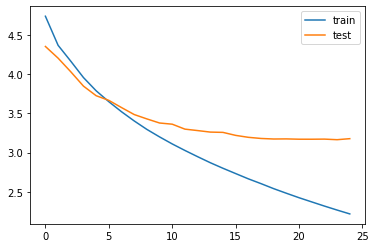

In [49]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 5) 인퍼런스 모델 구현

In [50]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [56]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 6) 모델 테스트

In [57]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [62]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


원문 : west bengal cm mamata banerjee has said she is willing to ally with congress to ensure that bjp is not elected in the elections adding that bjp leaders like hundred stating that she shares very good relations with congress leader sonia gandhi cm mamata described congress president rahul gandhi as much junior 
실제 요약 : cong remove bjp mamata 
예측 요약 :  mamata wins congress congress


원문 : google paid around to settle racial discrimination lawsuit filed by contractor while working on an google maps project the contractor said he was subjected to harassment including being asked if he was terrorist while gathering information about wifi signals inside stores he also claimed google withdrew his new contract after he complained about the harassment 
실제 요약 : google paid lawsuit 
예측 요약 :  google google google


원문 : social media giant facebook coo sandberg has donated nearly million worth facebook shares to the sandberg david family foundation according to regulatory document filed on thur

예측 요약 :  us space space


원문 : man was found dead at night shelter for the homeless run by the municipal corporation in aligarh on tuesday the police have sent his body for and launched an investigation to ascertain the cause of death meanwhile another homeless man at the shelter claimed that the deceased used to consume alcohol and sell blood to hospitals 
실제 요약 : man found dead night shelter 
예측 요약 :  man killed delhi man


원문 : according to reports saif ali khan daughter sara ali khan will be starring as the lead actress in hrithik roshan upcoming film super hrithik has reportedly approached the film director vikas bahl regarding sara casting and the talks have been initiated the film which is biopic on mathematician anand kumar is scheduled to release on january 
실제 요약 : sara ali khan star hrithik super reports 
예측 요약 :  saif hrithik star hrithik report


원문 : bengaluru based cab aggregator ola has raised billion in the biggest funding round in its history led by chinese internet g

예측 요약 :  pakistan jadhav jadhav jadhav


원문 : actor akshay kumar took to twitter to baahubali the conclusion stating he had finally seen the movie and it deserves every bit of and success he added that the film is taking indian cinema to an international level notably baahubali became the first ever indian movie to earn crore worldwide 
실제 요약 : baahubali every success akshay 
예측 요약 :  akshay hindi film


원문 : the national capital belongs to all citizens of india and not just to people living in delhi the centre on wednesday told the supreme court the centre which is currently involved in legal battle with the delhi government over the administrative of delhi had earlier said that it was union territory and not state 
실제 요약 : delhi nation centre tells sc 
예측 요약 :  thousands sc illegal centre


원문 : diana who made bollywood debut with in said that the time between her debut film and second film happy which released in was very took me while to figure out how to what direction to take she

<mark>[예시중 일부 구글 번역]</mark>

<b>1)옳은 예<br></b>
- 원문 : 소셜 미디어 거물인 페이스북 쿠 샌드버그는 목요일에 제출된 규제 문서에 따라 샌드버그 데이비드 가족 재단에 거의 백만 달러 상당의 페이스북 주식을 기부했습니다. 샌드버그는 현재 페이스북 지분을 소유하고 있습니다.
- 실제요약 : 페이스북, 자선단체 기부
- 예측요약 : 페이스북이 mn 페이스북을 판다 <b>->나름 요약이 잘 된 것 같다.</b>


<b>2)잘못된 예</br></b>
- 원문 : 구글은 구글 지도 프로젝트를 진행하는 동안 계약자가 제기한 인종 차별 소송을 해결하기 위해 돈을 지불했습니다. 계약자는 상점 내부에서 와이파이 신호에 대한 정보를 수집하는 동안 자신이 테러리스트인지 묻는 등 괴롭힘을 당했다고 말했습니다. 그는 또한 구글이 그 후 새 계약을 철회했다고 주장했습니다 그는 괴롭힘에 대해 불평했다
- 실제요약 : 구글 유료 소송
- 예측요약 : 구글 구글 구글 <b> -> 자주 등장하는 단어가 기업인 경우 별도의 전처리가 필요할것 같다.</b>

<b>3)잘못된 예</br></b>
- 원문 : 왕자는 일요일에 택시를 들이받은 후 왕자가 부상을 입고 아내가 사망했다고 경찰 관계자는 전했다.
- 실제요약 : 왕자 부상 아내 사망 사고
- 예측요약 : 부상당한 총격 사망  <b> -> 전처리에 taxi(택시) -Traffic Accident(교통사고) 객체명인식처리를 하였으면 개선 되었을것 같다. </b>

## Step 5. Summa을 이용해서 추출적 요약해보기

#### 1) 데이터 다운로드 하기

In [59]:
import requests
from summa.summarizer import summarize

In [70]:
data_news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data_news["text"]

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [74]:
print(data_news[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

#### 2) summarize 사용하기

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [87]:
print('Summary:')
print(summarize(data_news["text"][i], ratio=0.5))

Summary:
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


In [88]:
print('Summary:')
print(summarize(data_news["text"][i], ratio=0.5, split=True))

Summary:
['He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".']


In [86]:
print('Summary:')
print(summarize(data_news["text"][i], words=50))

Summary:
Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth.
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


### 평가기준
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
- 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

## 회고


1. 내용이 너무 방대해서 목차를 여러 번 정리하였다. 확실히 조금 더 이해에 도움이 된 것 같다.
2. 한글은 품사가 많아 텍스트 정규화가 어려울 것 같은 생각이 든다.
3. text_max_len, headlines_max_len의 값에 변화를 주어서 다양한 샘플의 비율 값을 확인하였는데 소중한 데이터가 버려지지 않도록 조정하는 것이 필수인듯하다.
4. 6) 단어 집합(vocabulary) 만들기 및 정수 인코딩 부분에서 단어 집합의 크기가 기존에 배웠던 노드 기준의 src_vocab 값으로 해야 할지, 데이터 기준으로 적용해야 할지 고민되었다. 관련해서 설명이 추가되었으면 하는 바람이다.
5. 훈련 데이터의 손실은 빠르게 감소하는 것을 볼 수 있었고, 검증 데이터의 손실은 10회 이상부터 둔화되며 19 정도부터 감소되지 않는 것으로 확인되었다.
6. summarize 사용하기에서 소수점 변화에 따라 노출 여부를 확인할 수 있었다. ratio= 0.4나 0.5의 경우 노출 별 차이는 나지 않았지만 0.05 및 0.005는 노출이 되지 않았다.
7. split=True 용도 및 words 값에 따라 변화되는 텍스트 양도 확인할 수 있었는데 위의 2개 요약본 텍스트가 words=30 정도인 것으로 확인 되었다.